In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# function recycled from capstone 1 used in part 3. 
def classifier_analysis(clf, xt, yt):
    ''' Predict and measure quality of model with a variety of metrics.   

    Parameters
    ----------

    xt : ndarray or DataFrame (n_samples, n_features)
             Feature data to test. n_features represents the number of features
             present in the data used to train the estimator clf

    yt : ndarray (n_samples, )
             Target data to test. 


    clf : scikit-learn estimator which has been fit to data with same number of columns as X_test

    '''
    y_predict = clf.predict(xt)
    y_predict_proba= clf.predict_proba(xt)[:,1]

    cm = confusion_matrix(yt, y_predict, labels=[0,1])#,dtype=float)
    # negative guesses
#     cm[:, 0] = cm[:, 0] / (len(yt) - yt.sum())
#     cm[:, 1] = cm[:, 1] / yt.sum()
    print('tn, fp, fn, tp', cm.ravel())
    _ = ConfusionMatrixDisplay(cm / (yt.size), [0,1]).plot()
    
    print(classification_report(yt, y_predict))

    roc_auc = roc_auc_score(yt, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(yt, y_predict_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    average_precision = average_precision_score(yt, y_predict_proba)
    precision, recall, thresholds = precision_recall_curve(yt, y_predict_proba)
    disp = plot_precision_recall_curve(clf, xt, yt)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    return roc_auc

# Part 1 : Exploratory Data Analysis

In [3]:
with open('logins.json', 'r') as file:
    data = json.load(file)

First, get an idea and make sure that the data is what we expect by looking at keys and values.

In [4]:
_, _, _  = print(data.keys()), print(len(data.values())), print(len(data['login_time']))

dict_keys(['login_time'])
1
93142


Ok, so now we know that there is only a single key, with "one value" which is a list of login times with 93142 elements.

In [5]:
df = pd.to_datetime(pd.Series(data['login_time'])).to_frame('login_time')
df.loc[:, 'count'] = 1
df = df.set_index('login_time')
df = df.groupby(pd.Grouper(freq='15Min')).count().reset_index()

Plot the time series of logins.

Text(0, 0.5, 'Frequency')

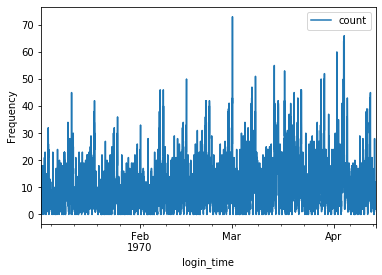

In [6]:
df.plot(x='login_time', y='count')
plt.ylabel('Frequency')

It's hard to see what is going on, even if the figure size is increased; instead, let's look at a window of the time series.

Text(0, 0.5, 'Frequency')

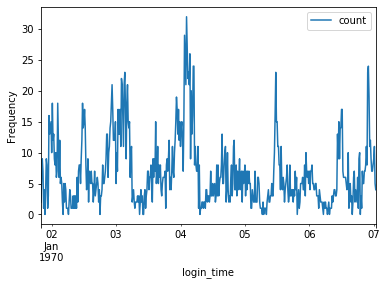

In [143]:
ax = df.iloc[:500].plot(x='login_time', y='count')
plt.ylabel('Frequency')

By plotting the first five hundred elements the plot resolution is on the order of days; there seems to be some periodicity or quasiperiodic behavior of the maxima. Let's see if its a 24-hour periodicity by labeling the daily maxima. 

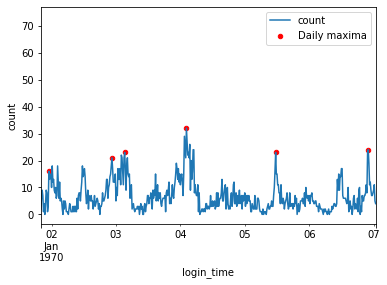

In [8]:
ax = df.iloc[:500].plot(x='login_time', y='count')
plt.ylabel('Frequency')

df_daily_max = pd.to_datetime(pd.Series(data['login_time'])).to_frame('login_time')
df_daily_max.loc[:, 'count'] = 1
df_daily_max = df_daily_max.set_index('login_time')
times_of_daily_maxima = (df_daily_max.groupby(pd.Grouper(freq='15Min')).count().groupby(pd.Grouper(freq='d'))
                        ).idxmax().iloc[:,0].values#.reset_index()
df[df.login_time.isin(times_of_daily_maxima)].plot.scatter(x='login_time', y='count',ax=ax,c='r',label='Daily maxima')

The red dots indicate daily maxima; the fact that they are not equally space implies that the seasonality is not 24 hours. 
The peaks seem to occur either once or twice per day, typically separated by 12 hours, but the pattern is quasiperiodic at best. Because of this, let's look at the average values to get more insight. 

Text(0.5, 1.0, 'Daily Average logins')

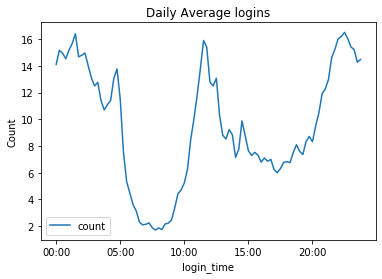

In [9]:
df.groupby(df.login_time.dt.strftime('%H:%M')).mean().plot()
plt.ylabel('Count')
plt.title('Daily Average logins')

This shows that, on average, the number of logins peaks every 12 hours; occuring around noon and midnight. This is somewhat surprising to me, because the information we were given was that all of these logins are occcuring in the *same* geographical region. Perhaps people need to relog upon the start of a new day? The appearance of additional maxima could be an indication of weekend behavior. 

# Part 2 : Experiments and metric design

***The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.***


### What I propose for the metric.

***What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?***

The goal of the cities is to encourage more cross traffic. Therefore our metric should represent this. 
The drivers are still paying the tolls, but now they are being reimbursed. Therefore, the change
in cross-traffic can be tracked via the change in the amount of tolls being paid. This choice
is the most obvious for two reasons: 1. If you drive between the cities you *must* pay the toll, meaning that the
toll is a direct proxy for cross traffic. 2. The
toll system is already in place and so there is no additional setup required. 

***Describe a practical experiment you would design to compare the effectiveness of the
    proposed change in relation to the key measure of success. Please provide details on:
        a. how you will implement the experiment
        b. what statistical test(s) you will conduct to verify the significance of the
    observation***


To test the effectiveness of the toll reimbursement program, the first step would be to collect data on the amount of tolls being paid after the new measure has been implemented. Once a sufficient sample size  distribution of  I believe that it is best to compile toll data such that the averages before and after the new measure can be tested for statistical significance. 

I think the most obvious statistical test is to use a t-test to compare the means of the tolls $\mu_1$, $\mu_2$ before and after the new measure is in place; aggregated by some time interval. If no distinction is to be made between the two populations of drivers then the seasonality can be averaged over (12 hour difference in circadian rhythms, so compute daily averages, possibly). This depends of course on how much data is available.  


***How you would interpret the results and provide recommendations to the city
    operations team along with any caveats.***

If the statistical testing rejects the null hypothesis that the before and after averages are equal, I would say that the toll system was a success and the new reimbursement measure is serving its purpose. One caveat however is that this does not imply that the drivers from both cities changed behavior. To investigate the effect on either population separately, it may be possible to use the seasonality of the different cities. Because we are told they are offset by 12 hours, it would perhaps be wise to look at the distributions of the tolls paid $\pm 6$ hours from these peaks, treating them as separate populations. Assuming that this is valid, if both populations showed an increase then I would say the project is a success. I think it is important to go even further, however, and try to investigate whether both populations of drivers showed a change in behavior. 

I think it is important to provide specific recommendations which are actionable, so I will now go into further detail
by assuming that one of the cities' drivers showed no statistically significant change in behavior. If it is decided that this is really important, then these drivers either need to be incentivized to go to the other cities or punished for staying in the same city. First, I would look at and perhaps survey why the drivers do not want to go to the other city; for example, perhaps a disparity in population means that one of the cities has worse traffic and so it is not cost effective to go to the other city. Perhaps the city could offer their drivers a rebate on fuel costs due to this. The additional incentives need not target a single population; by adding incentives that affect both populations, the change could possibly be increased even further, if so desired. 

# Part 3 : Ultimate user retention modeling.

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

    1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
    data for this analysis (a few sentences/plots describing your approach will suffice). What
    fraction of the observed users were retained?
    
    
There are not many features and so I will investigate most if not all of them by plotting their distributions and looking at
the relationships that I find the most relevant and useful in regards to retention. First import the json data and put it in a Pandas DataFrame for exploratory purposes



In [11]:
with open('ultimate_data_challenge.json', 'r') as file:
    ultimate_data = json.load(file)
    
ultimate_df = pd.json_normalize(ultimate_data)

ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Feature descriptions
    ● city: city this user signed up in
    ● phone: primary device for this user
    ● signup_date: date of account registration; in the form ‘YYYYMMDD’
    ● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
    ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    ● avg_rating_by_driver: the rider’s average rating over all of their trips
    ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    ● surge_pct: the percent of trips taken with surge multiplier > 1
    ● avg_surge: The average surge multiplier over all of this user’s trips
    ● trips_in_first_30_days: the number of trips this user took in the first 30 days after
    signing up
    ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
    FALSE otherwise
    ● weekday_pct: the percent of the user’s trips occurring during a weekday

First, see if there are any missing values.

In [12]:
ultimate_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

There are missing values for two numerical features, the average rating of the driver and the average rating *by* the driver (of the passenger). Because the rating of the driver is one of the primary sources of user feedback,  I think it is important to keep the feature for the modeling portion of this project. This means that I will have to impute the missing values so that the feature can be used for modeling. I'm going to use the median as the imputation value. My reasoning behind this is a rather reaching assumption regarding human psychology. If a rider experienced an absolutely terrible or absolutely wonderful ride, I feel like they would be more inclined to rate the driver than if they had a mediocre experience. For the categorical feature, phone type, simply introduce a new "Missing" Category. 

In [13]:
# Fill the numerical values with median
ultimate_df = ultimate_df.fillna(ultimate_df.median())

# Fill the remaining, categorical, missing values with "Missing". 
ultimate_df = ultimate_df.fillna('Missing')

Next, look at the distributions of (all) numerical features.

<Figure size 432x288 with 0 Axes>

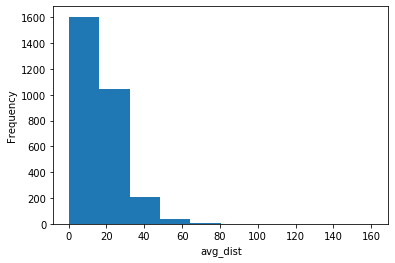

<Figure size 432x288 with 0 Axes>

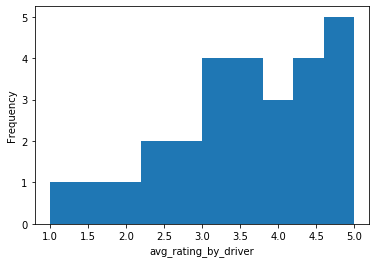

<Figure size 432x288 with 0 Axes>

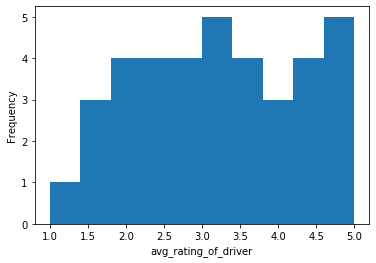

<Figure size 432x288 with 0 Axes>

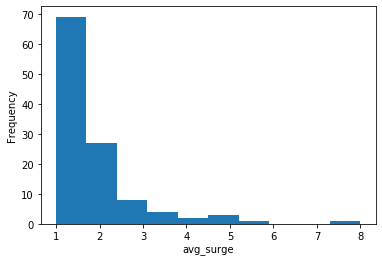

<Figure size 432x288 with 0 Axes>

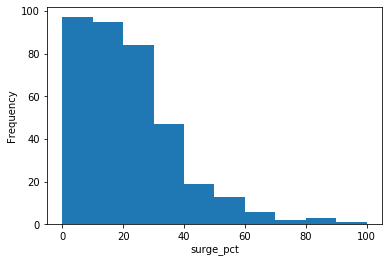

<Figure size 432x288 with 0 Axes>

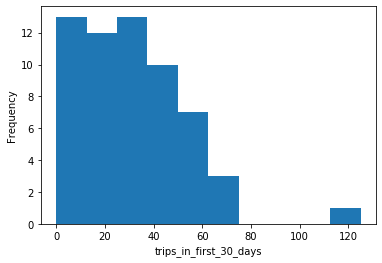

<Figure size 432x288 with 0 Axes>

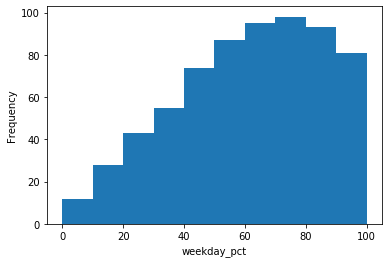

In [16]:
numerical_feature_value_counts = (ultimate_df.select_dtypes(include='number').unstack().groupby(level=0)
                                 ).value_counts().reset_index(level=1)
numerical_feature_value_counts.columns = ['Values', 'Count']

for feature in numerical_feature_value_counts.index.unique():
    _ = plt.figure()
    _ = numerical_feature_value_counts.loc[feature].plot.hist(y='Values', x='Count', legend=False)
    _ = plt.xlabel(feature)
    _ = plt.show()

There is nothing exceptionally pathological, but it might be wise to apply a logarithmic transformation to the average surge and average distance features, because of how clustered they are. Let's now begin the investigation of the prescribed quantity, user activity.

To determine whether or not a user is still active, it is convenient to create a datetime column based on the last trip date feature. This allows for comparison / slicing using inequalities. 

In [17]:
ultimate_df.loc[:, 'last_trip_date_dt'] =  pd.to_datetime(ultimate_df.last_trip_date).values

The most recent date isn't told to us so I will take the most recent date in the ```last_trip_date``` column as "the present"

In [18]:
present_date = ultimate_df.last_trip_date_dt.max()
print('The most recent date in the data set is {}'.format(present_date.date()))

The most recent date in the data set is 2014-07-01


So any users who have taken a trip occuring on or after the date below are considered active.

In [144]:
active_user_date = present_date - pd.Timedelta(days=30)

active_users = ultimate_df[ultimate_df.last_trip_date_dt >= active_user_date].index

Create a column which flags which users are active. I elect to use a new binary feature which I call "active". 1 if user is active, 0 if inactive.

In [21]:
ultimate_df.loc[:,'active'] = 0
ultimate_df.loc[active_users,'active'] = 1

Next, look at the distribution of the activity categories.

Only 37.608 percent of the total users were retained


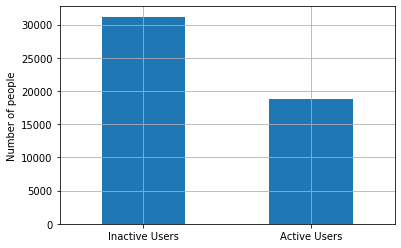

In [146]:
# For plot labeling purposes, map 0, 1 to Inactive, Active.
ultimate_df.active.map({0:'Inactive Users', 1:'Active Users'}).value_counts().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of people')
plt.grid(True)
print('Only {} percent of the total users were retained'.format(100*ultimate_df.active.sum()/ultimate_df.active.size))


I would say that the retention is not good; probably why we are investigating this. Because this is a phone app, the low hanging fruit is to see if there is any difference in the retention between phone types. If we count the number of users for each type of phone, we can simply add up the new "active" flag column.

In [23]:
# The number of people using each type of phone (or missing a value)
ultimate_df.phone.value_counts().sort_index()

Android    15022
Missing      396
iPhone     34582
Name: phone, dtype: int64

In [24]:
# For plot labeling purposes, map 0, 1 to Inactive, Active.
android_count, missing_count, iphone_count   = ultimate_df.phone.value_counts().sort_index()
android_retained, missing_retained, iphone_retained  = ultimate_df.groupby('phone').sum().active.sort_index()#.active.map({0:'Inactive',1:'Active'}).value_counts().plot.bar()
print('{:f} percent of Android users ({:d}), were retained.'.format(100*android_retained/android_count, android_count))
print('{:f} percent of Iphone users ({:d}), were retained.'.format(100*iphone_retained/iphone_count, iphone_count))
print('{:f} percent of users missing phone information ({:d}), were retained.'.format(100*missing_retained/missing_count, missing_count))

20.942617 percent of Android users (15022), were retained.
44.893297 percent of Iphone users (34582), were retained.
33.585859 percent of users missing phone information (396), were retained.


The sample size for each population is large, so it is unlikely that the different phone users had substantially different experiences with drivers and I would say this is likely due to a difference in app quality between the different environments. I would say is a quite common problem which affects android users (at least in my personal experience as an Android user). To be fair, let's check and see how each phone population rate their drivers.

In [25]:
ultimate_df.groupby('phone').avg_rating_of_driver.mean()

phone
Android    4.679803
Missing    4.683586
iPhone     4.636724
Name: avg_rating_of_driver, dtype: float64

Going by the averages, the android users actually had better trips! Therefore I think my suspicion that it is the app's fault seems even more likely.

#### 3. 
Build a predictive model to help Ultimate determine whether or not a user will be active
    in their 6th month on the system. Discuss why you chose your approach, what
    alternatives you considered, and any concerns you have. How valid is your model?
    Include any key indicators of model performance.


There are both categorical and numerical features (I'm counting boolean and datetime-like features as categorical). Because I am using a battery of scikit-learn regression classifiers I need to either discard or encode the categorical features. This is in fact what I will do. The one exception, however, is the feature last_trip_date. The dependent variable is created by placing the values in one of two bins and then taking the one-hot encoding for a single bin, namely, the "active" bin which contains last_trip_date values which are within 30 days of the latest date in the data set. This is the first reason why it is not included; the second reason is the fact that the last_trip_date column has a large number of unique values, meaning that the dimension of its encoding would dwarf the dimension of all other features, combined. Therefore, I exclude this feature from the training data. While time plays a role in this problem, it is not the form of time series prediction, rather, the problem can be phrased as "Given this set of values after six months, is the user active or inactive?". Meaning that there is not any need to be careful with the train-test splitting of the data with respect to time, because all independent variable information is available at the time of prediction. 

As previously mentioned, the categorical columns will be one-hot encoded. The numerical columns will be scaled using scikit-learn's StandardScaler, which subtracts the mean and divides by the standard deviation in a columnwise fashion. 

The scikit-learn classifiers/regression methods to be used are LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier. I am using more than one because it takes hardly any effort to test more than one. 

In [116]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import average_precision_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, SparsePCA 
from sklearn.linear_model import LogisticRegression

I find the Pandas "get_dummies" function easier to use than sklearn's OneHotEncoder. First, convert boolean column to integer.

In [117]:
ultimate_df.loc[:,'ultimate_black_user'] = ultimate_df.loc[:,'ultimate_black_user'].astype(int).values

Take the categorical columns to encode, drop the originals from the training data and add the encodings.

In [118]:
categorical_data = ultimate_df.select_dtypes(include=['object'])
cat_dummies = pd.get_dummies(ultimate_df.select_dtypes(include='object').drop(columns='last_trip_date'), drop_first=True)

Drop the original categorical columns, and select the dependent variable. 

In [119]:
# Get rid of the originals of the newly-encoded columns and the redundant datetime feature.
y = ultimate_df.active.values
X = ultimate_df.drop(columns=categorical_data.columns.tolist()+['last_trip_date','last_trip_date_dt','active'])
ultimate_black_user_column = X.ultimate_black_user
X = X.drop(columns=['ultimate_black_user'])

Now that we have the correct independent and dependent variables, we need to split into train and test sets before normalizing the numerical features; otherwise we mix information between training and testing sets.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [121]:
train_indices =  X_train.index
test_indices = X_test.index

In [122]:
sclr = StandardScaler()
_ = sclr.fit(X_train)
X_train = sclr.transform(X_train)
X_test = sclr.transform(X_test)

After normalizing the splits, we can finally combine the numerical and categorical columns (need to split the categorical variables now as well).

In [123]:
X_train.shape

(40000, 7)

In [124]:
X_train = np.concatenate((X_train, ultimate_black_user_column.values[train_indices].reshape(-1,1), 
                         cat_dummies.values[train_indices]),axis=1)

In [125]:
X_test = np.concatenate((X_test, ultimate_black_user_column.values[test_indices].reshape(-1,1), 
                         cat_dummies.values[test_indices]),axis=1)

In [126]:
# Check and ensure the shapes are correct
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40000, 42), (40000,), (10000, 42), (10000,))

As previously mentioned, use LogisticRegression, GradientBoostingClassifier, AdaBoostClassifer, RandomForestClassifier. 
Using a custom function I print out the classification report, confusion matrix (also visualized), the ROC curve, the ROC_AUC score, and the precision recall curve. In the visualization of the confusion matrix, I use the percentage of the total values that each category (false positive, true positive, false negative, true negative) represents. 

tn, fp, fn, tp [4555 1709 1274 2462]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      6264
           1       0.59      0.66      0.62      3736

    accuracy                           0.70     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.71      0.70      0.70     10000



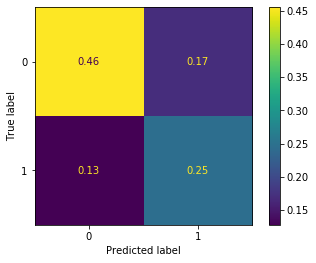

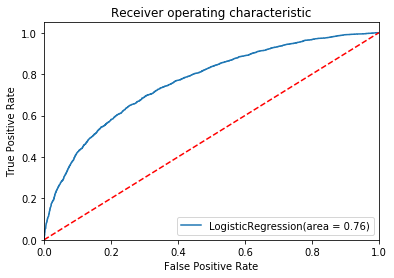

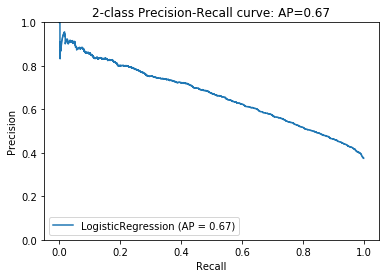

In [127]:
logistic_regression = LogisticRegression(class_weight='balanced')
_ = logistic_regression.fit(X_train, y_train)
logreg_roc_auc_test = classifier_analysis(logistic_regression, X_test, y_test)

tn, fp, fn, tp [5430  834 1352 2384]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6264
           1       0.74      0.64      0.69      3736

    accuracy                           0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000



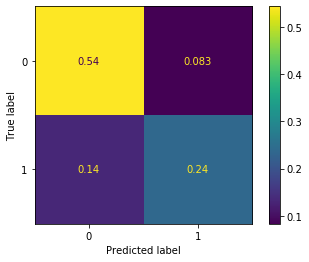

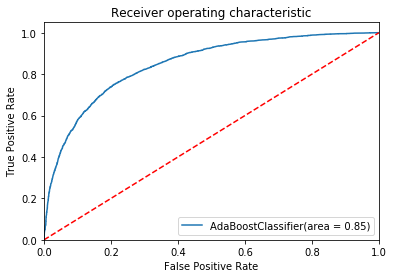

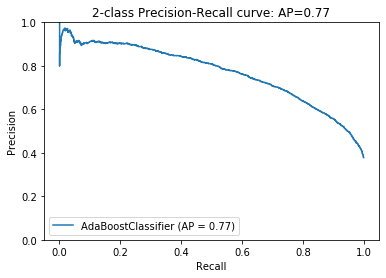

In [128]:
ada_boost = AdaBoostClassifier()
_ = ada_boost.fit(X_train, y_train)
adaboost_roc_auc_test = classifier_analysis(ada_boost, X_test, y_test)

tn, fp, fn, tp [5319  945 1316 2420]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6264
           1       0.72      0.65      0.68      3736

    accuracy                           0.77     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.77      0.77      0.77     10000



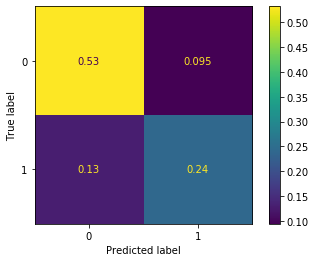

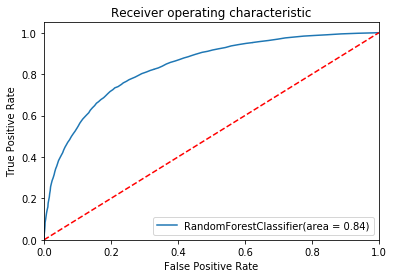

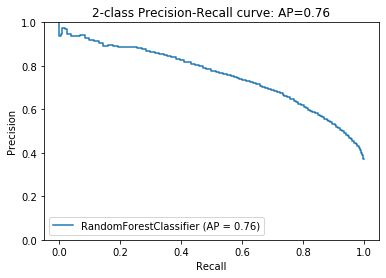

In [129]:
random_forest = RandomForestClassifier()
_ = random_forest.fit(X_train, y_train)
ranfor_roc_auc_test = classifier_analysis(random_forest, X_test, y_test)

tn, fp, fn, tp [5428  836 1309 2427]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6264
           1       0.74      0.65      0.69      3736

    accuracy                           0.79     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.79      0.78     10000



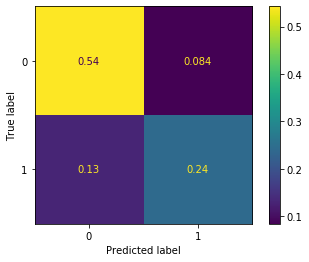

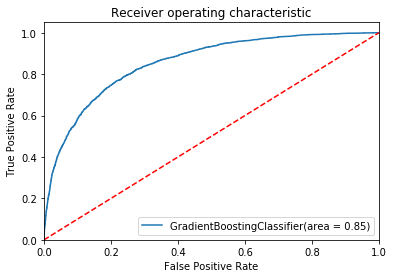

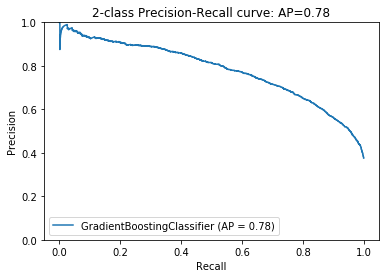

In [130]:
gradient_boost = GradientBoostingClassifier()
_ = gradient_boost.fit(X_train, y_train)
gradboost_roc_auc_test = classifier_analysis(gradient_boost, X_test, y_test)

Going by the ROC_AUC score, the GradientBoostingClassifier performs the best, and so I shall discuss only its results. The ROC curve depicts above a baseline performance of choosing 0 or 1 randomly; I believe that it is a good indication that the model is indeed useful in this case. In terms of each label, the model was better at predicting the inactive users as opposed to the active users. This is quantified by the precision and recall scores (or equivalently the f1-score which is roughly speaking an average of the two). The recall is the number of correctly predicted positives divided by the actual number of positives. The precision is the number of correctly predicted positives divided by the total number of predicted positives. 

In layman's terms, the model was able to correctly predict 66% of the active users and when it did predict the user would be active, it was right 74% of the time. 

The analysis of these values really depends on the perspective of the company; is it more important to identify the users that will become inactive, or identify those that will remain active. While similar, these are not in fact the same.



# 3. 
    
Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long-term rider retention (again, a few sentences will suffice).

To gain insight, we can look at the feature importances of the gradient boosting classifier, much like how we could have looked at the coefficients of a regression model.

In [139]:
f_importance = np.argsort(gradient_boost.feature_importances_)[::-1]


print('The top 10 most important features, in order, are:')
pd.concat((X, ultimate_black_user_column,
                         cat_dummies),axis=1).columns[f_importance[:10]].tolist()

The top 10 most important features, in order, are:


['avg_rating_by_driver',
 'surge_pct',
 "city_King's Landing",
 'weekday_pct',
 'phone_iPhone',
 'ultimate_black_user',
 'trips_in_first_30_days',
 'avg_dist',
 'city_Winterfell',
 'avg_rating_of_driver']

#### Recommendations based on feature importances.

1. The average rating by the driver is actually somewhat hard to interpret, as there typically isn't any restriction on who can use the app. One possible interpretation is that if a driver is a nicer person they are more likely to leave favorable reviews of their passengers; meaning that it actually reflects the driver not the passenger. 

2. The surge percentage indicates that more drivers should be hired because people don't like paying additional fees. 

3. The user's phone being an iPhone is relevant, I believe this can be interpreted that the Android app should be improved.  

4. The company should probably focus on the markets of King's landing and winterfell as they are having success there.

5. Because the amount of trips in the first 30 days matters, perhaps incentives could be offered which get the rider more accustom to using the app. Likewise for ultimate black rides. 

7. Lastly, I think it is fairly obvious that increasing the quality of drivers would benefit the company. 

# Future work and alternative methods

Possible alternatives are to use a different scaling of the numerical features and to test the inclusion/exclusion of different subsets of features using feature-selection techniques.

Note that these models were not tuned; they mostly used the default values with the exception of the class_weight='balanced' for the LogisticRegression instance. 